### Paxillin movie segmentation and object feature analysis

with Shailaja's movies

Liya Ding, 2024.03

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
czimovie_dir =  '/mnt/d/lding/FA/data/FA_movies_SS'
csv_output_dir = '/mnt/d/lding/FA/analysis_results/movies_SS/csv'
plot_output_dir = '/mnt/d/lding/FA/analysis_results/movies_SS/FA_plot'
seg_output_dir = '/mnt/d/lding/FA/analysis_results/movies_SS/FA_seg'

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)
if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

In [3]:
# build the colormap with iterative tab20
tab20 = cm.get_cmap('tab20', 20)
for i in range(10):
    tab20.colors = np.concatenate([tab20.colors,tab20.colors],axis=0)    
tab20.colors = np.concatenate([np.zeros([1,4]),tab20.colors],axis=0)
print(tab20.colors)

[[0.         0.         0.         0.        ]
 [0.12156863 0.46666667 0.70588235 1.        ]
 [0.68235294 0.78039216 0.90980392 1.        ]
 ...
 [0.85882353 0.85882353 0.55294118 1.        ]
 [0.09019608 0.74509804 0.81176471 1.        ]
 [0.61960784 0.85490196 0.89803922 1.        ]]


### for each movie run through all the time points

In [62]:
# flag for some optinal parts
flag_plot = True
flag_plot_save = False
flag_seg_save = True
flag_csv_save = True
flag_run_all = True
flag_panel_plot = False

In [63]:
prop_df_pax_all = pd.DataFrame(columns=['filename','cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                                'cell_edge_dist','cell_edge_orient','diff_orient'])

filenames = [x for x in os.listdir(czimovie_dir) if os.path.isfile(os.path.join(czimovie_dir, x)) and ('.czi' in x)]

# if not in run all mode, only test with the first image of the first movie
if not flag_run_all:
    filenames = filenames[1:2]

for filenameID in range(len(filenames)):
    print(filenameID)
    filename = filenames[filenameID]
    img = tifffile.imread(os.path.join(czimovie_dir,filename))
    time_length = img.shape[0]
    for timeID in range(time_length):
        prop_df_pax = pd.read_csv(os.path.join(csv_output_dir,'labelprop_SS_'+str(filenameID)+'_t'+str(timeID)+'.csv'))
        prop_df_pax_all = prop_df_pax_all.append(prop_df_pax)


0
1
2
3
4
5


In [66]:
prop_df_pax_all = prop_df_pax_all.append(prop_df_pax)


In [67]:
prop_df_pax_all.shape

(23990, 24)

In [69]:
prop_df_pax_all.to_csv(os.path.join(csv_output_dir,'all_labels.csv'))

(array([1.3274e+04, 4.3190e+03, 2.2520e+03, 1.5280e+03, 8.6400e+02,
        5.1100e+02, 3.7800e+02, 2.2500e+02, 1.5700e+02, 1.0300e+02,
        9.4000e+01, 7.0000e+01, 4.7000e+01, 4.0000e+01, 2.2000e+01,
        2.3000e+01, 1.5000e+01, 1.5000e+01, 1.6000e+01, 1.1000e+01,
        6.0000e+00, 6.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.0, 37.66, 73.32, 108.97999999999999, 144.64, 180.29999999999998,
        215.95999999999998, 251.61999999999998, 287.28, 322.93999999999994,
        358.59999999999997, 394.26, 429.91999999999996, 465.5799999999999,
        501.23999999999995, 536.9, 572.56, 608.2199999999999,
        643.8799999999999, 679

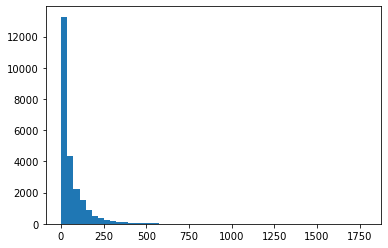

In [70]:
prop_df_pax_all_selected = prop_df_pax_all[['area', 'eccentricity', 'convex_area', 'bbox_area', 'equivalent_diameter', 'euler_number',
                                  'extent','filled_area','major_axis_length','mean_intensity',
                                  'minor_axis_length','orientation','perimeter','solidity',
                                  'cell_edge_dist','cell_edge_orient','diff_orient']]


plt.hist(prop_df_pax_all_selected['area'],50)

In [71]:
prop_df_pax_all.shape

(23990, 24)

14


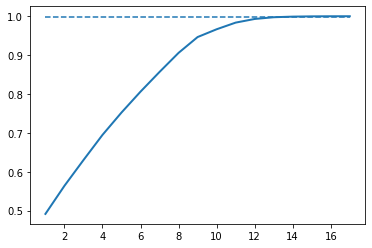

In [72]:
import sklearn
cdf = []
cdf = sklearn.preprocessing.scale(prop_df_pax_all_selected, axis=0)

cdf.shape

FA_pca = sklearn.decomposition.PCA()
FA_pca.fit(cdf)

fig = plt.plot(figsize=(10,4))
cumsum = np.cumsum(FA_pca.explained_variance_ratio_)
plt.plot(np.arange(1, FA_pca.n_components_ + 1),
           cumsum, 
           '-', linewidth=2)
n_pc = FA_pca.n_components_

for i in range(FA_pca.n_components_):
    if cumsum[i]>0.999:
        n_pc = i+1
        break
print(n_pc)

plt.hlines(cumsum[n_pc-1], xmin=1, xmax=FA_pca.n_components_, linestyle='dashed')


Text(0.5, 1.0, 'features12')

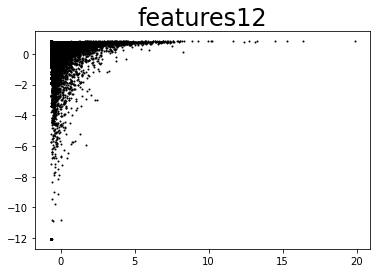

In [73]:
plt.scatter(cdf[:, 0], cdf[:, 1],c='k',s=1)
plt.title('features12', fontsize=24)

In [74]:
FA_pca.explained_variance_ratio_*100

array([4.91298324e+01, 7.23301889e+00, 6.62571433e+00, 6.47616359e+00,
       5.75960480e+00, 5.37410298e+00, 5.07351222e+00, 4.90533286e+00,
       4.06699107e+00, 2.00451458e+00, 1.71144880e+00, 9.39279432e-01,
       4.46427101e-01, 1.54851254e-01, 6.80958375e-02, 2.55845797e-02,
       5.52532253e-03])

Text(0.5, 1.0, 'PCA-1-2')

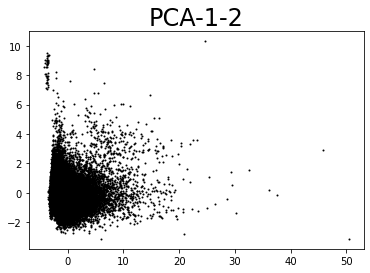

In [75]:
cdf_trans = FA_pca.transform(cdf)
plt.scatter(cdf_trans[:, 0], cdf_trans[:, 1],c='k',s=1)
plt.title('PCA-1-2', fontsize=24)

In [76]:
cdf_trans.shape

(23990, 17)

Text(0.5, 1.0, 'UMAP projection of the paxillin FA')

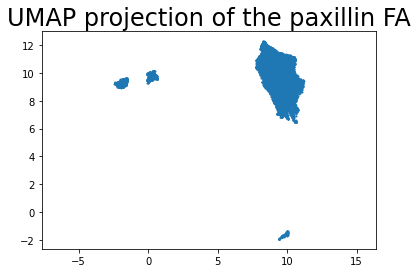

In [77]:
scaled_pax_PCA_data = StandardScaler().fit_transform(cdf_trans)

reducer = umap.UMAP(n_components=5,random_state=22)

reducer.fit(scaled_pax_PCA_data)

embedding = reducer.fit_transform(scaled_pax_PCA_data)
embedding.shape

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the paxillin FA', fontsize=24)


In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=1)
plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the paxillin FA', fontsize=24)

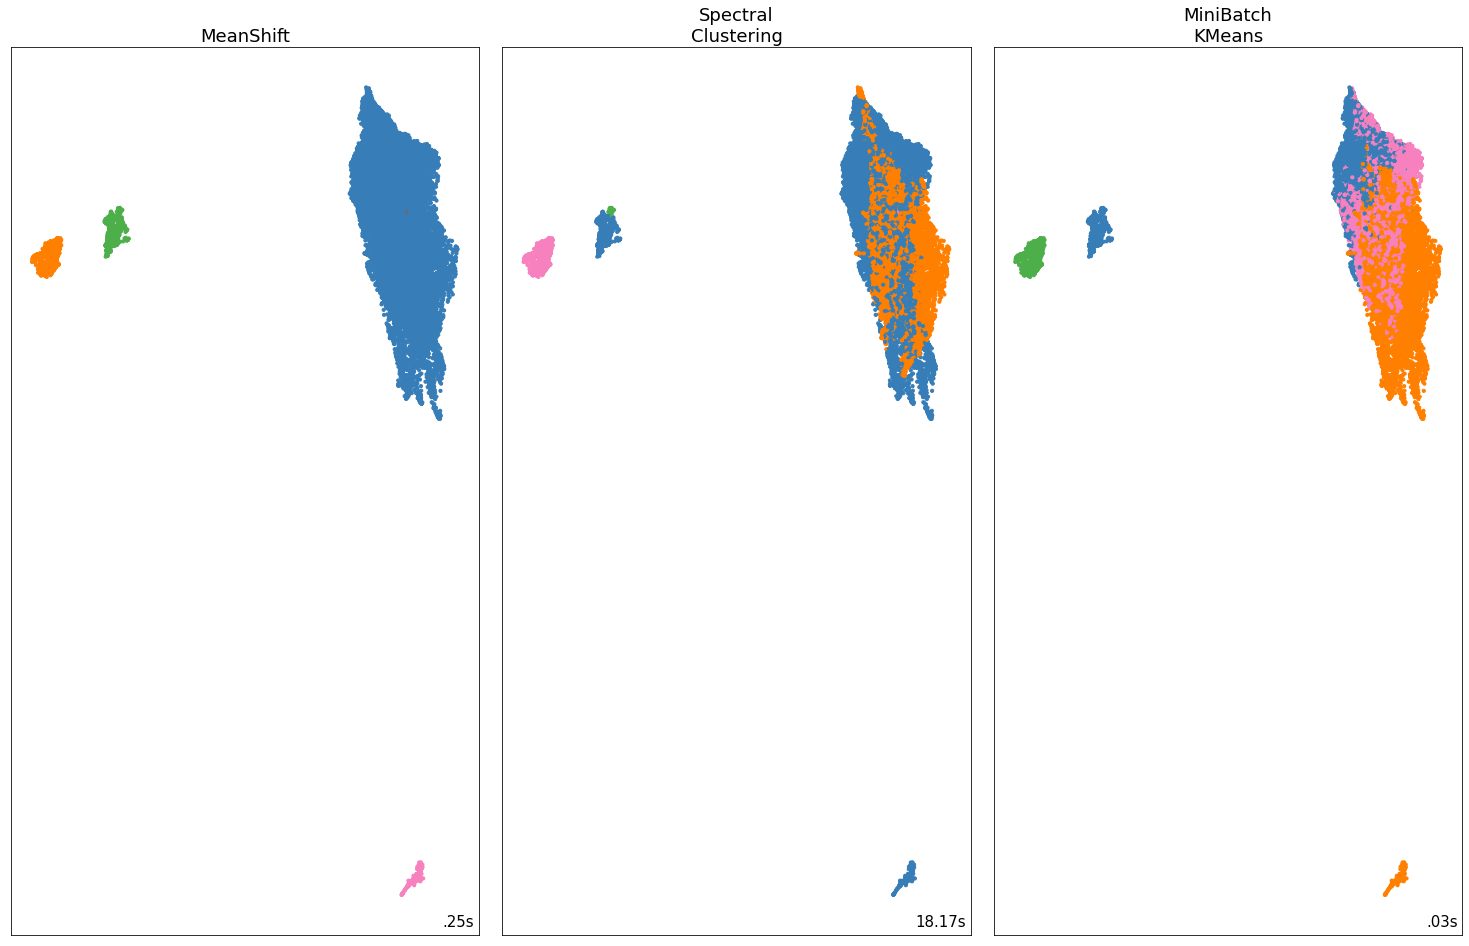

In [78]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 4,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    
    params = default_base.copy()

    params.update(algo_params)


    X = embedding[::1,:]
    y = np.zeros(cdf_trans[::1,:].shape[0])

    # X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    
    clustering_algorithms = (
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("MiniBatch\nKMeans", two_means),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)


        prop_df_pax_all[['cluster_ID_'+name[0:8]]] = y_pred.reshape([y_pred.shape[0],1])
        prop_df_pax_all.to_csv(os.path.join(csv_output_dir,'cluster_labels_allcels.csv'))

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        # plt.xlim(-2.5, 2.5)
        # plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

(array([22465.,   683.,   586.,   256.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

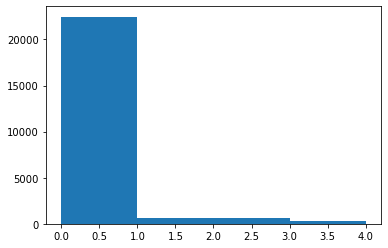

In [83]:
plt.hist(prop_df_pax_all['cluster_ID_MeanShif'],4)


In [39]:
y_pred[y_pred==2].shape

(19,)

In [31]:
y_pred.shape

(34644,)

In [32]:
prop_df_pax_all.shape

(34644, 23)

In [54]:
# AA = np.zeros([34644,1])
# AA[:] = y_pred
y_pred.reshape([34644,1]).shape


(34644, 1)

In [60]:

prop_df_pax_all.drop(['cluster_ID_KNN'])

KeyError: "['cluster_ID_KNN'] not found in axis"

In [56]:
  prop_df_pax.to_csv(os.path.join(csv_output_dir,'labelprop_SS_'+str(filenameID)+'_t'+str(timeID)+'.csv'))


,cell_ID,time_point,area,bbox_area,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,cell_edge_dist,cell_edge_orient,diff_orient,Unnamed: 0,cluster_ID_KNN
0,0.0,0.0,243.0,1316.0,275.0,0.994916,17.589690,1.0,0.184650,243.0,...,0.202014,5.635591,0.509347,114.124892,0.883636,28.0,-2.034444,0.597802,0.0,3.0
1,0.0,0.0,316.0,1550.0,364.0,0.994291,20.058507,1.0,0.203871,316.0,...,0.178347,6.612457,0.520216,125.195959,0.868132,55.0,-0.463648,0.983864,1.0,3.0
2,0.0,0.0,34.0,96.0,38.0,0.977987,6.579525,1.0,0.354167,34.0,...,0.169192,2.990840,0.557890,25.556349,0.894737,41.0,0.000000,0.557890,2.0,3.0
3,0.0,0.0,64.0,170.0,69.0,0.978653,9.027033,1.0,0.376471,64.0,...,0.029999,4.114086,0.500809,40.420310,0.927536,8.0,1.975688,1.474879,3.0,3.0
4,0.0,0.0,78.0,266.0,88.0,0.985403,9.965575,1.0,0.293233,78.0,...,0.195956,4.134766,0.588529,47.112698,0.886364,63.0,0.785398,0.196869,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2788,0.0,23.0,40.0,56.0,43.0,0.776822,7.136496,1.0,0.714286,40.0,...,0.060914,5.662208,-0.649585,21.899495,0.930233,91.0,2.356194,0.135814,2788.0,0.0
2789,0.0,23.0,48.0,77.0,51.0,0.930901,7.817640,1.0,0.623377,48.0,...,0.146319,4.782578,0.405327,27.899495,0.941176,30.0,-1.570796,1.165469,2789.0,0.0
2790,0.0,23.0,30.0,42.0,31.0,0.803075,6.180387,1.0,0.714286,30.0,...,0.219928,4.773732,0.568174,18.485281,0.967742,105.0,-2.034444,0.538974,2790.0,3.0
2791,0.0,23.0,30.0,35.0,31.0,0.725887,6.180387,1.0,0.857143,30.0,...,0.212421,5.158638,0.203509,18.242641,0.967742,91.0,-2.034444,0.903640,2791.0,0.0
